In [1]:
import numpy
import mitsuba as mi 
import drjit as dr 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE3D.Coefficient import *
from PDE3D.utils import *
from PDE3D.BoundaryShape import *
from PDE3D.Solver import *
import argparse
from PDE3D.utils import *
import os

In [2]:
resolution_tex = [16,16,32]

In [3]:
def function1(points : mi.Point3f):
    freq1= 0.3
    a = 2.0* dr.pi * freq1
    b = 4.0* dr.pi * freq1
    theta = 0
    cosAx = dr.cos(a*points[1] + theta)
    sinBy = dr.sin(b*points[0] + theta)
    return dr.exp(-points[0]*points[0] + cosAx*sinBy)

def function2(points : mi.Point3f):
    minval = 0
    maxval = 1.
    freq0 = 0.3
    freq1 = 0.3
    return (.5 + .5*dr.sin(2.* dr.pi * freq0 *points[0])*dr.cos(0.5 *dr.pi* freq1 * points[1]))

def function3(points : mi.Point3f):
    freq = 0.2
    k = dr.pi * freq
    theta = dr.pi/2
    sinAx = dr.sin(k * points[0] + theta)
    cosAx = dr.cos(k * points[0] + theta)
    sinBy =  dr.sin(2*k*points[1] + theta)
    cosBy =  dr.cos(2*k*points[1] + theta)
    sinCz = dr.sin(3*k*points[2] + theta)
    return sinAx*cosBy + (1 - cosAx)*(1 - sinBy) + 2 * sinCz*sinCz + 0.3

def function4(points : mi.Point3f):
    decrease = 0.8
    return 2/dr.exp(dr.square(points*decrease)* dr.square(points[1]*decrease) * dr.square(points[2] * decrease))

def function5(points : mi.Point3f):
    return dr.sin(dr.square(dr.norm(points))) + 1

def function6(points : mi.Point3f):
    freq1= 0.2
    a = 2.0* dr.pi * freq1
    b = 2.0* dr.pi * freq1
    decrease_rate = 0.8
    theta = dr.pi/2
    cosAx = dr.cos(a*points[1] + theta)
    sinBy = dr.sin(b*points[0] + theta)
    return (cosAx*sinBy + 1) * dr.exp(-dr.abs(points[2]) * decrease_rate)

fnc = function6

In [4]:
slices = []
num_slice = 9
start = 2.7
offset = -0.7
scale_slice = 9
for i in range(num_slice):
    slices.append(Slice(offset = i * offset + start, scale = scale_slice, axis = "z"))

In [5]:
name = "motorbike-engine"
folder_name = os.path.join(PATH, "scenes", name)
xml_name = os.path.join(folder_name, "scene.xml")
sdf_data = np.load(os.path.join(folder_name, "sdf.npy"))[::2, ::2, ::2]

sdf = SDF(sdf_data, dirichlet = [], scale = 12, xml_name = xml_name)

bbox = sdf.bbox
bbox_pad = (bbox.max - bbox.min) / 10
bbox_coeff = mi.ScalarBoundingBox3f(bbox.min - bbox_pad, bbox.max + bbox_pad)
points_bbox = create_bbox_points(bbox_coeff, resolution_tex, spp = 1, centered = True)
print(bbox)

fnc_vals = fnc(points_bbox)
vals_tex, _ = create_volume_from_result(fnc_vals, resolution_tex)
f = TextureCoefficient("source", bbox_coeff, vals_tex[0])

fnc_vals = f.get_value(points_bbox)
mask = sdf.inside_closed_surface_mask(points_bbox)
fnc_vals = dr.select(mask, fnc_vals, dr.nan)
input_range = [dr.min(fnc_vals)[0], dr.max(fnc_vals)[0]]

TypeError: SDF.__init__() got an unexpected keyword argument 'xml_name'

In [ ]:
data_holder = DataHolder(shape = sdf, α = f)
print(data_holder.σ_bar)
print(input_range)
print(np.min(vals_tex))

[21.4465]
[0.0033604693599045277, 1.5160140991210938]
0.00021255226


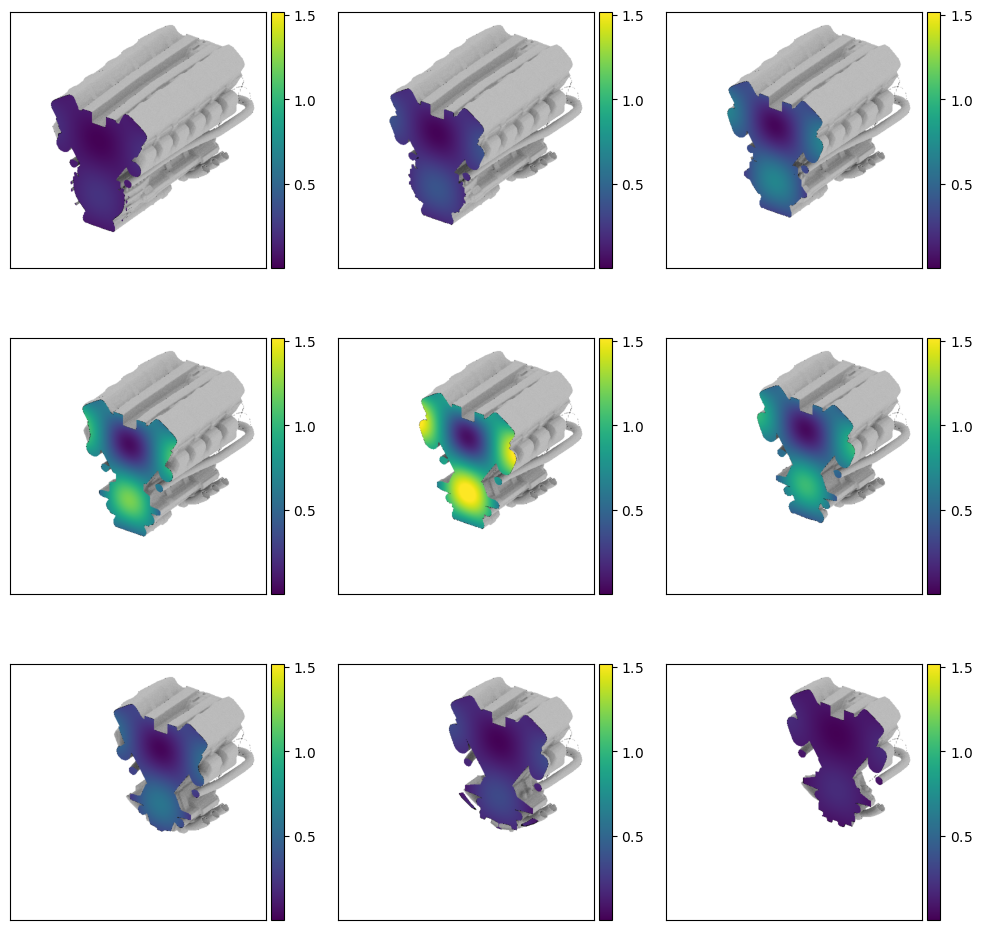

In [ ]:
cam_res = [512, 512]
res_slice = [512, 512]
spp = 64
downsample = 1
cam_origin = mi.ScalarPoint3f([7,7,10])
scale_cam = 1/5
cam_target = mi.ScalarPoint3f([0.0,0.0,0.0])
cam_up = mi.ScalarPoint3f([0,1,0])
cmap = "viridis"
fig, ax = plt.subplots(num_slice//3, 3, figsize = (12, (num_slice//3) * 4))
for i in range(num_slice):
    r = i // 3
    c = i % 3
    coeff3D, coeff_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                                scale_cam=scale_cam, cam_up = cam_up, slice = slices[i], cam_target = cam_target, coeff=f,
                                input_range = input_range)
    plot_image_3D(coeff3D, ax[r,c], norm = coeff_norm, cmap = cmap)